In [ ]:
# Importing necessary classes 
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import tensorflow as tf
import seaborn as sn

In [ ]:
# Loading the dataset and shaping it into a time series dataset
rainfall= pd.read_csv('/content/2619492.csv')
rainfall[["DATE"]] = rainfall[["DATE"]].apply(pd.to_datetime)
rainfall = rainfall.set_index('DATE')
rainfall.head(3)

,PRCP
DATE,
1990-01-01,0.0
1990-02-01,0.0
1990-03-01,0.0


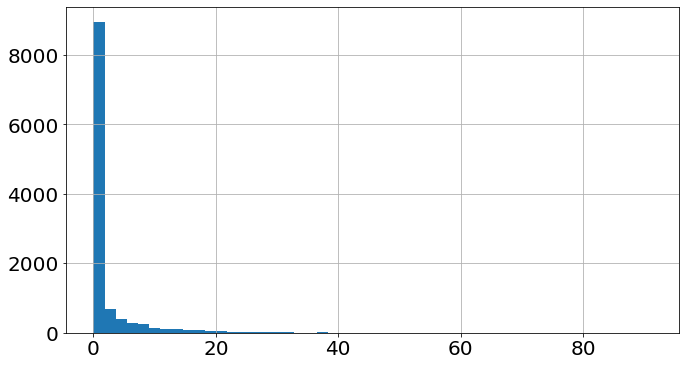

In [ ]:
#Plotting the histogram of dataset
plt.figure(figsize=(11, 6))
plt.rc('font', size=20)         # controls default text sizes
plt.rc('axes', titlesize=22)    # fontsize of the axes title
plt.rc('axes', labelsize=22)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)   # fontsize of the tick labels
plt.rc('ytick', labelsize=20)  # fontsize of the tick labels
plt.rc('legend', fontsize=22)   # legend fontsize
plt.rc('figure', titlesize=23)  # fontsize of the figure title
series = rainfall.PRCP
series.hist(bins=50)
plt.show()

In [ ]:
# Box-Cox Transformation Function
def boxcox1p(data):
  p1data= data+1
  bcdata, bclambda = boxcox(p1data)
  return bcdata, bclambda

In [ ]:
# Inverse Box-Cox transformation Function
def inv_boxcox1p(bcdata, bclambda):
  data=inv_boxcox(bcdata, bclambda)-1
  return data

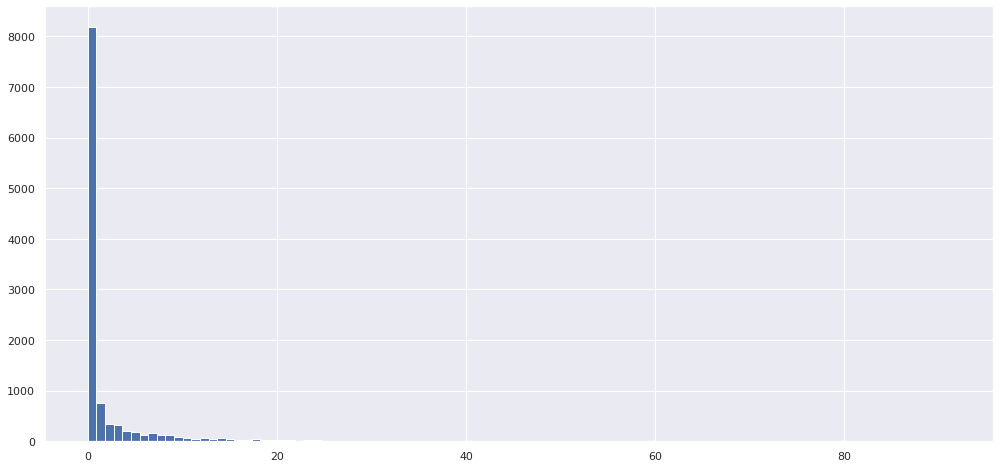

In [ ]:
#Calling the Box-Cox transformation function to normalize the data distribution
inv_data, lam_value = boxcox1p(rainfall.PRCP) 
plt.hist(inv_data, bins=100)
plt.show()

In [ ]:
#Scaling the data for better results 
scaler= MinMaxScaler(feature_range=(0,1))
data = inv_data.reshape(-1,1)
scaler.fit(data)
rain_data = scaler.transform(rain_data)[:,0]

In [ ]:
#Function for making windowed dataset
from numpy import array
def split_sequences(series, window):
  x, y= list(), list()
  for i in range(len(series)):
    end= i+ window
    if end>len(series)-1:
      break
    seq_x, seq_y= series[i:end], series[end]
    x.append(seq_x)
    y.append(seq_y)
  return array(x), array(y)

In [ ]:
#Dividing the dataset into train and test subsets
train_data = new_Data[0:9058]
valid_data = new_Data[9058:]
window_size = 70
x_train, y_train = split_sequences(train, window_size)
x_test, y_test = split_sequences(test, window_size)

In [ ]:
#Reshaping the test and test input data for LSTM model
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [ ]:
# Building the LSTM model
model = Sequential()
model.add(LSTM(32, input_shape=(window_size, 1), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(32,))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='relu'))

In [ ]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 40))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mean_squared_error"])
print(model.summary())

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_36 (LSTM)               (None, 70, 32)            4352      
_________________________________________________________________
dropout_36 (Dropout)         (None, 70, 32)            0         
_________________________________________________________________
lstm_37 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dropout_37 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_36 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_37 (Dense)             (None, 1)                 17        
Total params: 13,217
Trainable params: 13,217
Non-trainable params: 0
_________________________________________________

In [ ]:
# LSTM model training phase 
print("Starting to fit")
history = model.fit(x_train, y_train, epochs=100, batch_size=60, verbose=1, validation_data=(x_train, y_train), callbacks=[lr_schedule])

Starting to fit
Epoch 1/100
150/150 [==============================] - 14s 69ms/step - loss: 0.1059 - mean_squared_error: 0.2118 - val_loss: 0.1141 - val_mean_squared_error: 0.2282
Epoch 2/100
150/150 [==============================] - 10s 64ms/step - loss: 0.1059 - mean_squared_error: 0.2118 - val_loss: 0.1140 - val_mean_squared_error: 0.2281
Epoch 3/100
150/150 [==============================] - 10s 64ms/step - loss: 0.1061 - mean_squared_error: 0.2121 - val_loss: 0.1140 - val_mean_squared_error: 0.2280
Epoch 4/100
150/150 [==============================] - 10s 64ms/step - loss: 0.1058 - mean_squared_error: 0.2117 - val_loss: 0.1140 - val_mean_squared_error: 0.2279
Epoch 5/100
150/150 [==============================] - 10s 64ms/step - loss: 0.1059 - mean_squared_error: 0.2119 - val_loss: 0.1139 - val_mean_squared_error: 0.2278
Epoch 6/100
150/150 [==============================] - 9s 63ms/step - loss: 0.1058 - mean_squared_error: 0.2116 - val_loss: 0.1139 - val_mean_squared_error: 0.

In [ ]:
model.evaluate(x_test, y_test)

69/69 [==============================] - 1s 5ms/step - loss: 0.0781 - mean_squared_error: 0.1562


[0.0780753344297409, 0.1561506688594818]

In [ ]:
#Predicting the values for test set
result= model.predict(x_test)
result= scaler.inverse_transform(result)
result= inv_boxcox1p(result, lam_value)
y_test= stan.inverse_transform(y_test)
y_test= inv_boxcox1p(y_test, lam_value)
score= math.sqrt(mean_squared_error(y_valid, result))
score

6.181927704609131

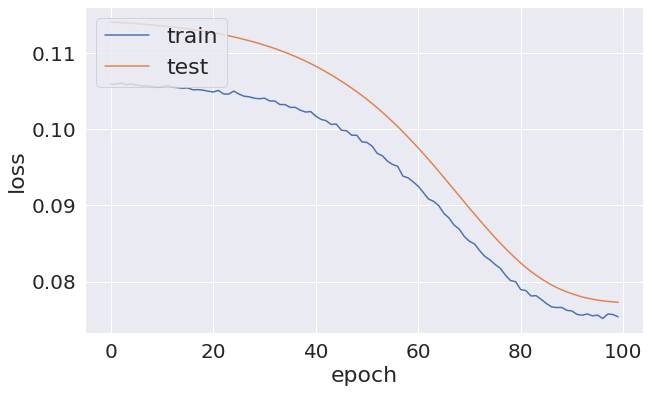

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#Defining average and naive forecast functions
def naiveForecast(x_data):
    # Expected Shape of x_data: (number of samples, number of readings per sample, 1)
    # Shape of forecast: (number of samples, )
    forecast = x_data[:,-1,0]
    return forecast

def avgForecast(x_data):
    # Expected Shape of x_data: (number of samples, number of readings per sample, 1)
    # Shape of forecast: (number of samples, )
    forecast = np.mean(x_data[:,:,0], axis=1)
    return forecast

naive_forecast = naiveForecast(x_test)
avg_forecast = avgForecast(x_test)

In [ ]:
avg_forecast= scaler.inverse_transform(avg_forecast.reshape(-1,1))[:,0]
avg_forecast = inv_boxcox1p(avg_forecast, lam_value)
naive_forecast= scaler.inverse_transform(naive_forecast.reshape(-1,1))[:,0]
naive_forecast = inv_boxcox1p(naive_forecast, lam_value)

In [ ]:
rmse_avg= math.sqrt(mean_squared_error(y_test, futureAvgForecast))
rmse_naive= math.sqrt(mean_squared_error(y_test, naive_forecast))

In [ ]:
rmse_avg

6.192282157406738

In [ ]:
rmse_naive

7.96751120227184